# Choice Set space for Neural Data

 The idea is to create a choice set that: samples the same SV difference (+ - some variation) with different trials  

In [ ]:
#Import the relevant libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
#pd.options.display.max_rows = 999
#pd.options.display.max_columns = 999

# 1. Input: patient's alpha and beta parameters

In [ ]:
#Define files & data pathway MAC OS
'''delete the comments and use the code if you are using a MAC'''
#patient_code = 'patient1_calibration'
#patient_split_dir = '/Volumes/UCDN/Santiago_Guardo/data/split'
#utility_dir = '/Volumes/UCDN/Santiago_Guardo/data/utility'
#utility_analysis = '/Volumes/UCDN/Santiago_Guardo/data/utility/split_CRDM_analysis.csv'
#parameters = pd.read_csv(utility_analysis)
#parameters

In [ ]:
#Define the files and their pathway, I think this may work for both MAC and PC
path= 'Z:/Santiago_Guardo/data' #Specify where the data is stored in the FileShare
patient_code = 'patient1_calibration' #Specify the patient's code
patient_split_dir = os.path.join(path,'split') 
patient_trials = os.path.join(patient_split_dir,'{}/crdm/{}_crdm.csv').format(patient_code,patient_code) #This is the psychopy output CSV

trials = pd.read_csv(patient_trials)

utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CRDM_analysis.csv')
parameters = pd.read_csv(utility_analysis)

print('loading fn: {}'.format(patient_trials))
print('loading fn: {}'.format(utility_analysis))


# 1. Plotting raw behavior

In [124]:
#df from original trials output
df =  trials[['crdm_trial_type', 'crdm_domain','crdm_sure_amt', 'crdm_lott_bot', 'crdm_lott_top', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_choice', 'crdm_choice2','crdm_lott','crdm_lott2']].copy()

#filtering out practice and Nan values
df = df.loc[df['crdm_trial_type'] != 'practice']
df = df[df['crdm_choice'].notna()]

#Adding the lotterys
df['value_reward'] = df['crdm_lott_bot'] +  df['crdm_lott_top']

#Dropping unneccesary columns
df = df.drop(columns=['crdm_trial_type','crdm_lott_bot','crdm_lott_top']).reset_index(drop=True)

#Organizing
column_order = ['crdm_sure_amt', 'crdm_domain', 'crdm_lott_p','value_reward', 'crdm_amb_lev', 'crdm_choice', 'crdm_choice2', 'crdm_lott', 'crdm_lott2']
df = df[column_order]
dfgains = df.loc[df['crdm_domain'] == 'gain']
dfloss = df.loc [df['crdm_domain'] == 'loss']

dfgains


,crdm_sure_amt,crdm_domain,crdm_lott_p,value_reward,crdm_amb_lev,crdm_choice,crdm_choice2,crdm_lott,crdm_lott2
3,5.0,gain,50.0,40.0,0.0,1.0,lott,1.0,win
5,5.0,gain,38.0,40.0,0.0,1.0,lott,0.0,lose
8,5.0,gain,38.0,50.0,0.0,1.0,lott,0.0,lose
11,5.0,gain,50.0,15.0,0.0,1.0,lott,0.0,lose
12,5.0,gain,38.0,30.0,0.0,1.0,lott,0.0,lose
13,5.0,gain,50.0,5.0,0.0,1.0,lott,0.0,lose
14,5.0,gain,75.0,15.0,0.0,1.0,lott,1.0,win
15,5.0,gain,50.0,20.0,74.0,0.0,sure,NaN,NaN
19,5.0,gain,50.0,50.0,50.0,0.0,sure,NaN,NaN
21,5.0,gain,38.0,5.0,0.0,0.0,sure,NaN,NaN


Text(0.5, 1.0, 'Choosing the lottery v.s value of the lottery for GAINS')

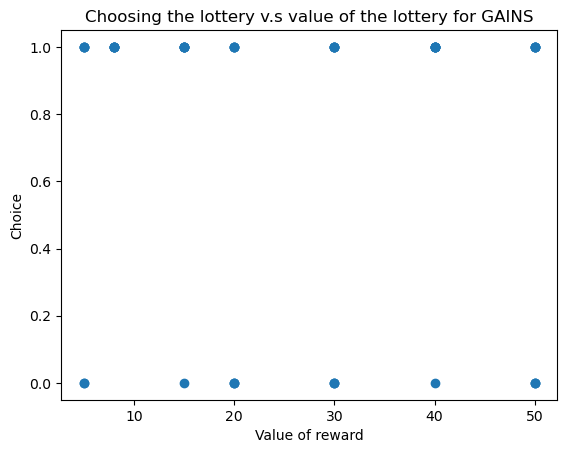

In [125]:
#Scatter Plot
plt.figure()
x =dfgains['value_reward']
y= dfgains['crdm_choice']
plt.scatter(x,y)
plt.xlabel('Value of reward')
plt.ylabel('Choice')
plt.title('Choosing the lottery v.s value of the lottery for GAINS')


Text(0.5, 1.0, 'Choosing the lottery v.s value of the lottery for LOSSES')

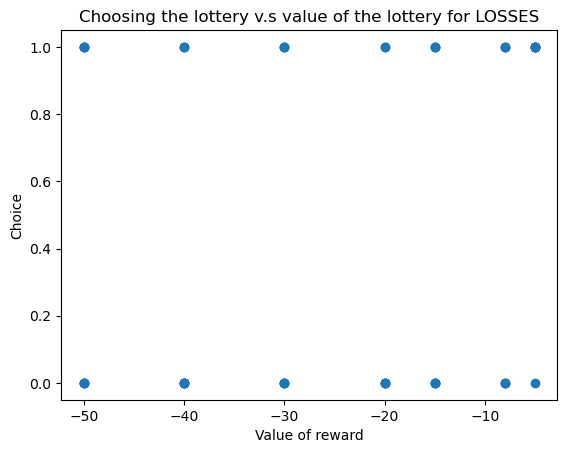

In [126]:
#Scatter Plot
plt.figure()
x =dfloss['value_reward']
y= dfloss['crdm_choice']
plt.scatter(x,y)
plt.xlabel('Value of reward')
plt.ylabel('Choice')
plt.title('Choosing the lottery v.s value of the lottery for LOSSES')

# 2. Running the model  

In [ ]:

#Define the parameter values for the given participant. 
filtered_parameters = parameters[parameters['subject'] == patient_code]

# Create alpha_pos and alpha_neg variables
alpha_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'alpha'].values[0]
alpha_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'alpha'].values[0]

beta_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'beta'].values[0]
beta_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'beta'].values[0]

print("alpha_pos:", alpha_pos)
print("alpha_neg:", alpha_neg)

print("beta_pos:", beta_pos)
print("beta_pos:", beta_neg)

